# Spatial Generalized Dissimilarity Mixed Modelling (spGDMM) of plankton community composition
# Demo

This notebook demonstrates fitting a spatial generalized dissimilarity model to predict compositional turnover (β-diversity) from environmental gradients. The spGDMM extends classical GDM by incorporating spatial effects and feature importance weighting through I-spline transformations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.spatial.distance import pdist
from spgdmm import spGDMM, plot_isplines, plot_crps_comparison

## Load Data

Load pre-processed environmental variables (temperature, salinity, vorticity) and biological observations at 80 spatial locations, plus gridded environmental fields for spatial prediction. Data obtained from SINMOD ocean model.

In this case, the data is from day 105 of the year, i.e. 15th April 2019. It contains information at 80 locations:

Features/predictors:
- Temperature
- Salinity
- Vorticity

Response/Target:
- Biomass of 5 plankton groups (diatoms, flagellates, ciliates, bacteria, and heterotrophic nanoflagellates (HNANO))

In [2]:
data = np.load("demo_data/day105.npz", allow_pickle=True)

xc, yc       = data["xc"].astype(float), data["yc"].astype(float)
temperature  = data["temperature"].astype(float)
salinity     = data["salinity"].astype(float)
vorticity    = data["vorticity"].astype(float)
biomass      = data["biomass"].astype(float)

grid_xc, grid_yc           = data["grid_xc"].astype(float), data["grid_yc"].astype(float)
grid_temperature            = data["grid_temperature"].astype(float)
grid_salinity               = data["grid_salinity"].astype(float)
grid_vorticity              = data["grid_vorticity"].astype(float)
ny_g, nx_g = grid_xc.shape

## Prepare Training and Test Sets

Randomly split observations into training (n=60) and test (n=20) sets. The response variable is pairwise Bray–Curtis dissimilarity, quantifying compositional turnover between all site pairs (1770 and 190 pairs, respectively).

In [3]:
rng = np.random.default_rng(1)
perm = rng.permutation(len(xc))
train_idx, test_idx = perm[:60], perm[60:80]

def make_X(idx):
    """Create predictor DataFrame with spatial coordinates and environmental variables."""
    return pd.DataFrame({
        "xc": xc[idx], "yc": yc[idx], "time_idx": np.zeros(len(idx)),
        "temperature": temperature[idx], "salinity": salinity[idx], "vorticity": vorticity[idx],
    })

X_train, X_test = make_X(train_idx), make_X(test_idx)

# Compute pairwise Bray-Curtis dissimilarity (response variable)
# Results in n*(n-1)/2 pairwise comparisons per set
y_train = np.clip(pdist(biomass[train_idx], "braycurtis"), 1e-8, None)
y_test  = np.clip(pdist(biomass[test_idx],  "braycurtis"), 1e-8, None)

## Fit spGDMM

Configure and fit the model using Hamiltonian Monte Carlo (HMC) via the `nutpie` sampler. The model uses I-splines to capture non-linear environmental effects and estimates feature importance weights (α) when `alpha_importance=True`.

In [4]:
model = spGDMM(
    distance_measure = "euclidean",
    alpha_importance = True,
    sampler_config   = {"draws": 500, "tune": 500, "chains": 2, "target_accept": 0.95},
)
idata = model.fit(X_train, y_train, random_seed=1)

Fitting model... with random seed: 1 1
[spGDMM] Starting _transform_for_training...
[spGDMM] Calculating pairwise distances for 60 locations...
[spGDMM] Calculating I-spline bases for predictors...
[spGDMM] _transform_for_training complete.
[spGDMM] Generated X_GDM with shape (1770, 20) and columns: ['temperature_I1', 'temperature_I2', 'temperature_I3', 'temperature_I4', 'temperature_I5', 'salinity_I1', 'salinity_I2', 'salinity_I3', 'salinity_I4', 'salinity_I5', 'vorticity_I1', 'vorticity_I2', 'vorticity_I3', 'vorticity_I4', 'vorticity_I5', 'Dist_I1', 'Dist_I2', 'Dist_I3', 'Dist_I4', 'Dist_I5']


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, beta, alpha, sigma2]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 56 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [alpha, beta, beta_0, log_y, sigma2]
Sampling: [log_y]


Output()

## Check Convergence Diagnostics

Assess MCMC convergence using summary statistics (R-hat, effective sample size) and trace plots. R-hat values near 1.0 and high ESS indicate good convergence.

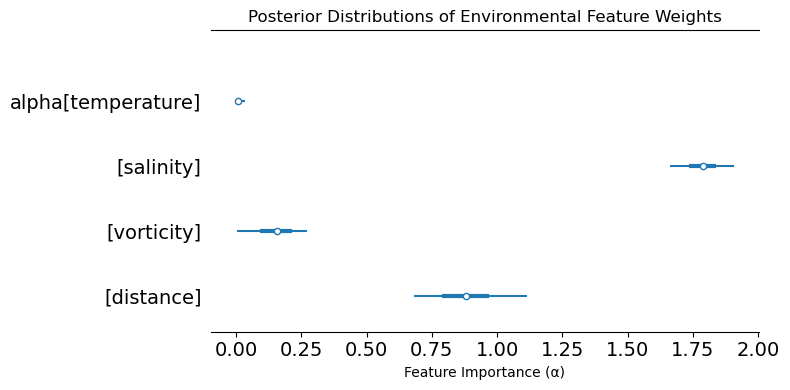

In [6]:
# Forest plot showing posterior distributions of alpha weights
fig, ax = plt.subplots(figsize=(8, 4))
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.9, ax=ax)
ax.set_xlabel("Feature Importance (α)")
ax.set_title("Posterior Distributions of Environmental Feature Weights")
plt.tight_layout()
plt.show()

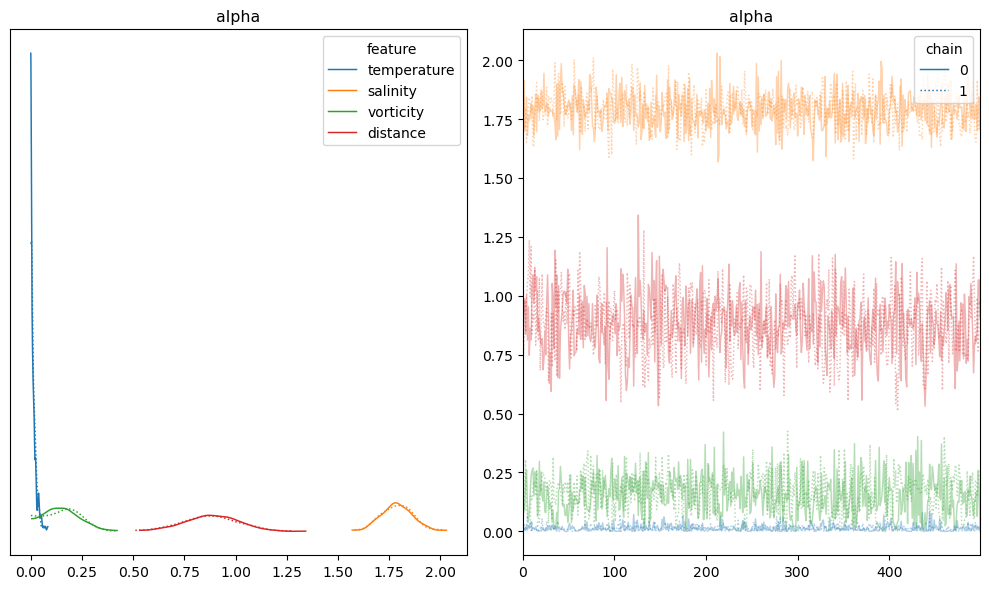

In [5]:
# Visualize trace plots for alpha importance weights
az.plot_trace(idata, var_names=["alpha"], compact=True, figsize=(10, 6), legend=True)
plt.tight_layout()
plt.show()

In [10]:
# Display summary statistics for key parameters
print("Convergence Summary:")
az.summary(idata)

Convergence Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[temperature],0.014,0.014,0.000,0.039,0.000,0.001,574.0,389.0,1.01
alpha[salinity],1.788,0.076,1.650,1.931,0.002,0.002,970.0,822.0,1.00
alpha[vorticity],0.155,0.085,0.004,0.295,0.004,0.003,382.0,211.0,1.00
alpha[distance],0.880,0.131,0.629,1.115,0.005,0.004,742.0,705.0,1.00
"beta[temperature, 1]",0.215,0.171,0.000,0.528,0.005,0.005,989.0,466.0,1.00
"beta[temperature, 2]",0.218,0.162,0.001,0.521,0.004,0.005,1224.0,611.0,1.00
"beta[temperature, 3]",0.185,0.162,0.000,0.485,0.005,0.005,729.0,489.0,1.00
"beta[temperature, 4]",0.165,0.139,0.000,0.418,0.005,0.005,813.0,500.0,1.00
"beta[temperature, 5]",0.217,0.179,0.001,0.562,0.005,0.007,1194.0,556.0,1.00
"beta[salinity, 1]",0.012,0.010,0.000,0.030,0.000,0.000,672.0,458.0,1.00


## Evaluate Predictive Performance

Generate posterior predictive samples for test pairs and evaluate using the Continuous Ranked Probability Score (CRPS). Left panel compares model versus null baseline; right panel shows CRPS skill score (1 − CRPS/CRPS_null), where values >0 indicate improvement over the null.

/cluster/home/haroldh/spGDMM/spgdmm/src/spgdmm/model.py:280: UserWarning: 2 env values were clipped to predictor_mesh bounds.
  warnings.warn(f"{n_clipped} env values were clipped to predictor_mesh bounds.")
Sampling: [log_y]


Output()


Using overridden sample_posterior_predictive!


Saving idata


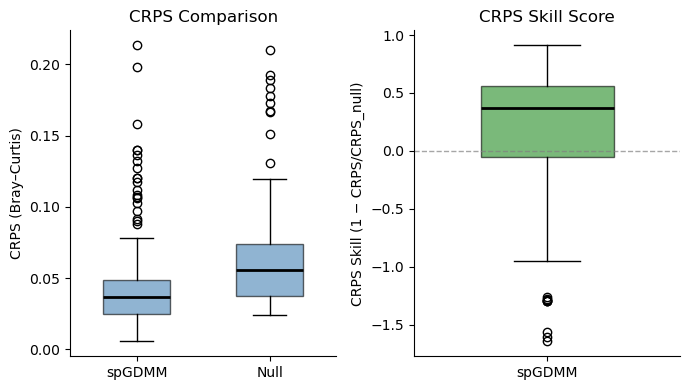

In [8]:
# Generate posterior predictive samples for test set
y_pred = model.predict_posterior(X_test, y_pred_obs=y_test, extend_idata=False)

# Evaluate on original Bray-Curtis scale (model predicts log-dissimilarity)
fig, axes = plot_crps_comparison(y_test, np.exp(y_pred), y_train, use_log=False, figsize=(7, 4))
plt.show()

## Map Biological Space

Project the transformed environmental features (I-spline space) onto three principal components to visualize compositional structure. RGB channels encode the first three PCs. Of course, more complex methods (e.g. Deep Learning) could be used to visua

/cluster/home/haroldh/spGDMM/spgdmm/src/spgdmm/model.py:280: UserWarning: 23090 env values were clipped to predictor_mesh bounds.
  warnings.warn(f"{n_clipped} env values were clipped to predictor_mesh bounds.")


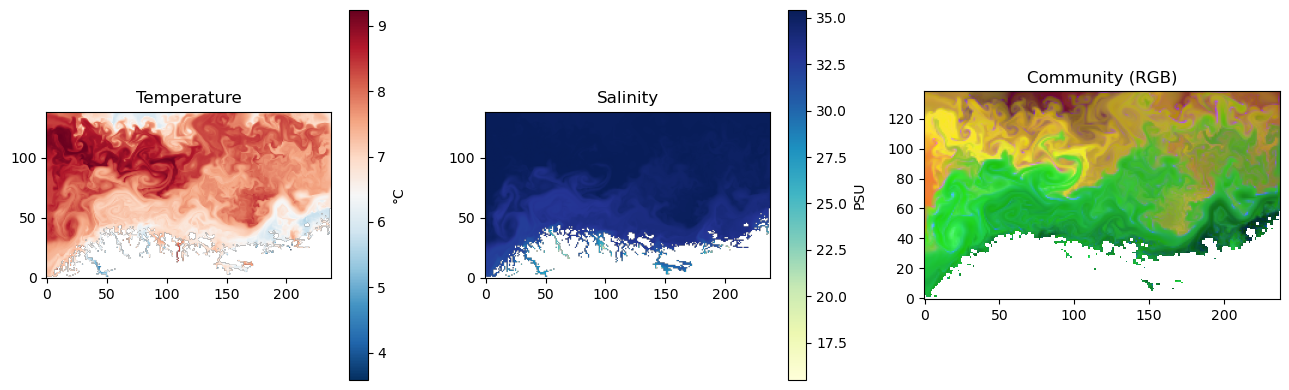

In [12]:
# Prepare grid of prediction locations
grid_index = pd.MultiIndex.from_arrays([grid_yc.ravel(), grid_xc.ravel()], names=["yc", "xc"])
X_grid = pd.DataFrame({
    "xc": grid_xc.ravel(), "yc": grid_yc.ravel(), "time_idx": np.zeros(ny_g * nx_g),
    "temperature": grid_temperature.ravel(), "salinity": grid_salinity.ravel(), "vorticity": grid_vorticity.ravel(),
}, index=grid_index)

# Project transformed features to RGB space via PCA
rgb_img = model.rgb_biological_space(X_grid, add_idata=False).values[0]

# Align coordinate system with environmental grids
rgb_img = np.swapaxes(rgb_img, 0, 1)

# Visualize environmental gradients and inferred community structure
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
im0 = axes[0].imshow(grid_temperature, origin="lower", cmap="RdBu_r")
plt.colorbar(im0, ax=axes[0], label="°C"); axes[0].set_title("Temperature")
im1 = axes[1].imshow(grid_salinity, origin="lower", cmap="YlGnBu")
plt.colorbar(im1, ax=axes[1], label="PSU"); axes[1].set_title("Salinity")
axes[2].imshow(rgb_img, origin="lower"); axes[2].set_title("Community (RGB)")
plt.tight_layout()
plt.show()

## Inspect I-spline Response Curves

Visualize the fitted non-linear response functions for each environmental predictor. Each plot shows individual I-spline basis functions (colored lines), their weighted sum (black line with credible interval), and the estimated importance weight (α).

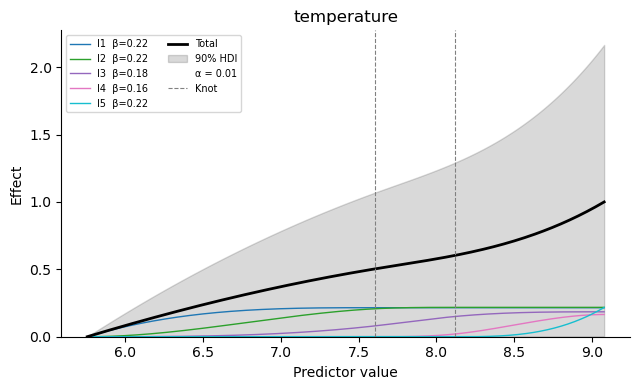

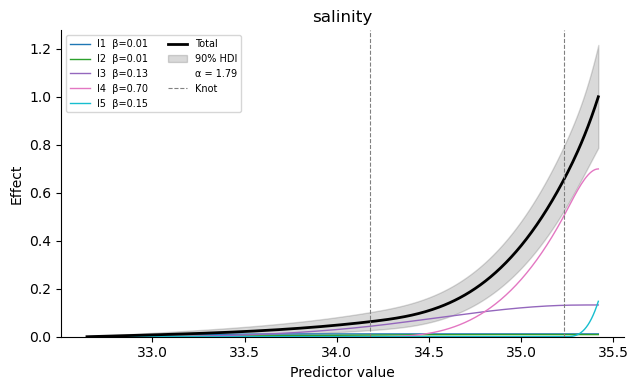

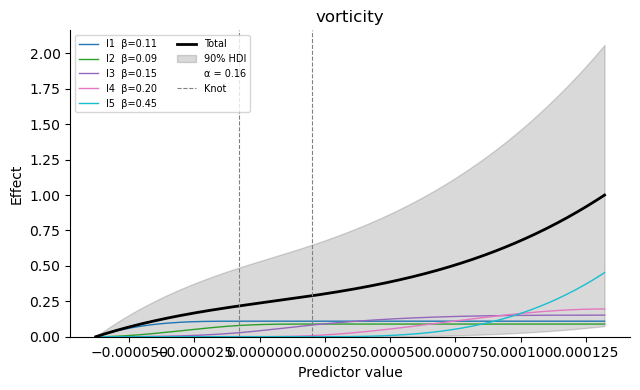

In [11]:
plot_isplines(model)